In [37]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [38]:
# Đọc và xử lý dữ liệu
data = pd.read_csv('./BNB Historical Data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
prices = data['Price'].values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(prices.reshape(-1, 1))
data_scaled

array([[0.00314696],
       [0.00374638],
       [0.00329682],
       ...,
       [0.87776296],
       [0.87597968],
       [0.88796811]])

In [39]:
# Chia dữ liệu
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

In [40]:
# Tạo chuỗi thời gian
def create_sequences(data, seq_len, pred_len):
    sequences = []
    for i in range(len(data) - seq_len - pred_len):
        seq = data[i:i + seq_len]
        target = data[i + seq_len: i + seq_len + pred_len]
        sequences.append((seq, target))
    return sequences

seq_len = 96
pred_len_30 = 30
pred_len_60 = 60
pred_len_90 = 90

train_sequences_30 = create_sequences(train_data, seq_len, pred_len_30)
test_sequences_30 = create_sequences(test_data, seq_len, pred_len_30)
train_sequences_60 = create_sequences(train_data, seq_len, pred_len_60)
test_sequences_60 = create_sequences(test_data, seq_len, pred_len_60)
train_sequences_90 = create_sequences(train_data, seq_len, pred_len_90)
test_sequences_90 = create_sequences(test_data, seq_len, pred_len_90)

In [41]:
# Chuyển đổi dữ liệu sang tensor
def prepare_tensors(sequences, device):
    X, y = zip(*sequences)
    X = np.array(X)
    y = np.array(y)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    return X_tensor, y_tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_30, y_train_30 = prepare_tensors(train_sequences_30, device)
X_test_30, y_test_30 = prepare_tensors(test_sequences_30, device)
X_train_60, y_train_60 = prepare_tensors(train_sequences_60, device)
X_test_60, y_test_60 = prepare_tensors(test_sequences_60, device)
X_train_90, y_train_90 = prepare_tensors(train_sequences_90, device)
X_test_90, y_test_90 = prepare_tensors(test_sequences_90, device)

In [42]:
# Định nghĩa mô hình Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, num_encoder_layers, num_decoder_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, d_model*2, dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_encoder_layers)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model, n_heads, d_model*2, dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_decoder_layers)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, input_dim)

    def forward(self, src, tgt):
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)
        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(tgt, memory)
        output = self.decoder(output)
        return output

input_dim = 1
d_model = 512
n_heads = 8
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.1

model = TransformerModel(input_dim, d_model, n_heads, num_encoder_layers, num_decoder_layers, dropout)
model.to(device)

c:\Users\VU HOANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=1024, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1024, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dr

In [43]:
# Huấn luyện và dự đoán
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X.transpose(0, 1), batch_y.transpose(0, 1))
            loss = criterion(outputs.transpose(0, 1), batch_y)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X.transpose(0, 1), batch_y.transpose(0, 1))
            predictions.append(outputs.transpose(0, 1).cpu().numpy())
    return np.concatenate(predictions, axis=0)

In [44]:
# Huấn luyện và dự đoán cho 30 ngày
train_loader_30 = DataLoader(TensorDataset(X_train_30, y_train_30), batch_size=32, shuffle=True)
test_loader_30 = DataLoader(TensorDataset(X_test_30, y_test_30), batch_size=32, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader_30, criterion, optimizer, epochs=10)
predictions_30 = predict(model, test_loader_30)
predictions_30 = scaler.inverse_transform(predictions_30.reshape(-1, 1))

# Huấn luyện và dự đoán cho 60 ngày
train_loader_60 = DataLoader(TensorDataset(X_train_60, y_train_60), batch_size=32, shuffle=True)
test_loader_60 = DataLoader(TensorDataset(X_test_60, y_test_60), batch_size=32, shuffle=False)

train_model(model, train_loader_60, criterion, optimizer, epochs=10)
predictions_60 = predict(model, test_loader_60)
predictions_60 = scaler.inverse_transform(predictions_60.reshape(-1, 1))

# Huấn luyện và dự đoán cho 90 ngày
train_loader_90 = DataLoader(TensorDataset(X_train_90, y_train_90), batch_size=32, shuffle=True)
test_loader_90 = DataLoader(TensorDataset(X_test_90, y_test_90), batch_size=32, shuffle=False)

train_model(model, train_loader_90, criterion, optimizer, epochs=10)
predictions_90 = predict(model, test_loader_90)
predictions_90 = scaler.inverse_transform(predictions_90.reshape(-1, 1))

Epoch [1/10], Loss: 0.0877
Epoch [2/10], Loss: 0.0679
Epoch [3/10], Loss: 0.0692
Epoch [4/10], Loss: 0.0687
Epoch [5/10], Loss: 0.0940
Epoch [6/10], Loss: 0.0886
Epoch [7/10], Loss: 0.0722
Epoch [8/10], Loss: 0.0514
Epoch [9/10], Loss: 0.2035
Epoch [10/10], Loss: 0.0229
Epoch [1/10], Loss: 0.0892
Epoch [2/10], Loss: 0.1137
Epoch [3/10], Loss: 0.0748
Epoch [4/10], Loss: 0.0644
Epoch [5/10], Loss: 0.0804
Epoch [6/10], Loss: 0.0646
Epoch [7/10], Loss: 0.0653
Epoch [8/10], Loss: 0.1172
Epoch [9/10], Loss: 0.0543
Epoch [10/10], Loss: 0.0564
Epoch [1/10], Loss: 0.0491
Epoch [2/10], Loss: 0.1091
Epoch [3/10], Loss: 0.0466
Epoch [4/10], Loss: 0.0653
Epoch [5/10], Loss: 0.0857
Epoch [6/10], Loss: 0.0500
Epoch [7/10], Loss: 0.0363
Epoch [8/10], Loss: 0.1168
Epoch [9/10], Loss: 0.0842
Epoch [10/10], Loss: 0.0482


ValueError: x and y must have same first dimension, but have shapes (384,) and (7740, 1)

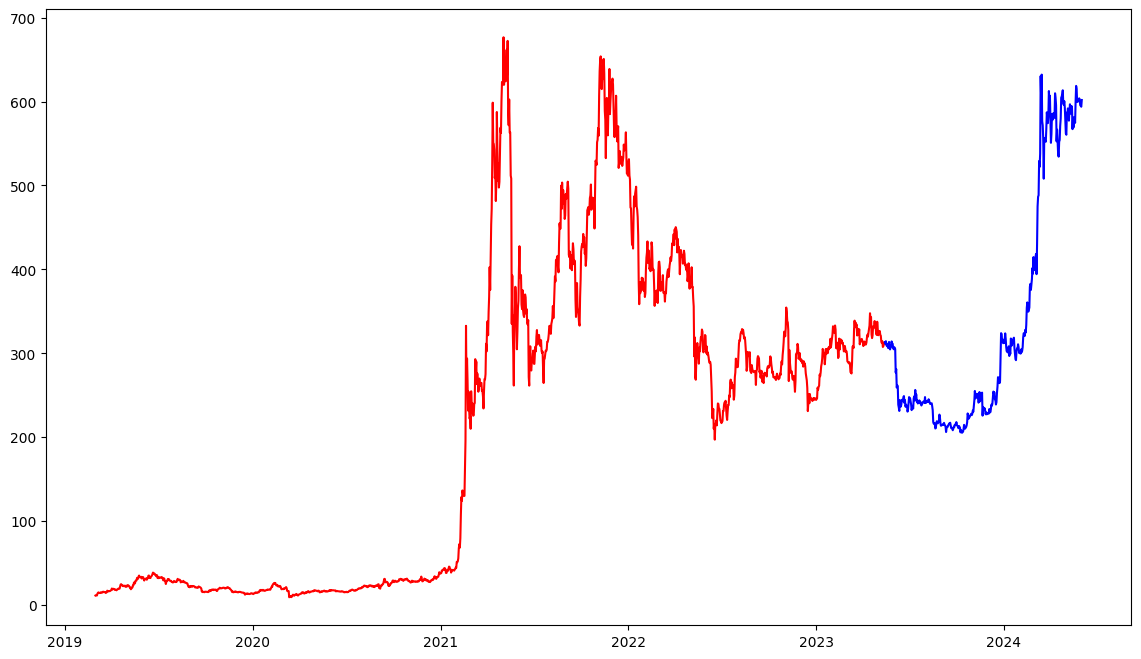

In [58]:
# Chuẩn bị dữ liệu cho biểu đồ
train_prices = scaler.inverse_transform(train_data)
test_prices = scaler.inverse_transform(test_data)

test_loader = DataLoader(TensorDataset(X_test_30, y_test_30), batch_size=32, shuffle=False)
predictions_test = predict(model, test_loader)
predictions_test = scaler.inverse_transform(predictions_test.reshape(-1, 1))

predictions_30 = predictions_30.reshape(-1, 1)
predictions_60 = predictions_60.reshape(-1, 1)
predictions_90 = predictions_90.reshape(-1, 1)

dates = data['Date']
train_dates = dates[:train_size]
test_dates = dates[train_size:]
predict_dates_30 = pd.date_range(start=test_dates.iloc[-1], periods=30+1)
predict_dates_60 = pd.date_range(start=test_dates.iloc[-1], periods=60+1)
predict_dates_90 = pd.date_range(start=test_dates.iloc[-1], periods=90+1)

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
plt.plot(train_dates, train_prices, label='Train', color='r')
plt.plot(test_dates, test_prices, label='Test', color='blue')
plt.plot(test_dates, predictions_test, label='Predict Test', color='green')
plt.plot(predict_dates_30, predictions_30, label='Predict 30 days', color='magenta')
plt.plot(predict_dates_60, predictions_60, label='Predict 60 days', color='cyan')
plt.plot(predict_dates_90, predictions_90, label='Predict 90 days', color='brown')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction with Transformer')
plt.legend()
plt.grid(True)
plt.show()